### Resamples and reprojects the 'classified' mnfi .tif files. Uses reference grid.

In [1]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.enums import Resampling as ResamplingEnum
from rasterio.coords import BoundingBox
from rasterio.plot import show

In [2]:
# Directories
input_directory = "/scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi/"
output_resampled_directory = "/scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10/"
output_reprojected_directory = "/scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/"
reference_grid_path = "/scratch/project_2000908/nousu/mNFI_to_NEP/air_temperature.tif"

# Parameters
block_size = int(10000 / 16)  # 10 km / 16 m resolution = 625
nodata_value = -9999

# Ensure output directories exist
os.makedirs(output_resampled_directory, exist_ok=True)
os.makedirs(output_reprojected_directory, exist_ok=True)

# List .tif files in input directory
input_files = [f for f in os.listdir(input_directory) if f.endswith('.tif')]

# Load reference raster transform and shape
with rasterio.open(reference_grid_path) as ref:
    target_crs = ref.crs
    target_transform = ref.transform
    target_width = ref.width
    target_height = ref.height

# Process each file
for input_file in input_files:
    print(f"Processing file: {input_file}")

    input_path = os.path.join(input_directory, input_file)
    resampled_output_path = os.path.join(output_resampled_directory, f"{input_file}")
    reprojected_output_path = os.path.join(output_reprojected_directory, f"{input_file}")

    # Resample to 10x10 km
    with rasterio.open(input_path) as src:
        data = src.read(1)
        data[data == nodata_value] = np.nan

        h, w = data.shape
        h_crop = (h // block_size) * block_size
        w_crop = (w // block_size) * block_size
        data = data[:h_crop, :w_crop]

        # Block-wise averaging
        data_blocks = data.reshape(h_crop // block_size, block_size, -1, block_size)
        block_means = np.nanmean(data_blocks, axis=(1, 3))

        # Compute new transform for resampled raster
        new_transform = rasterio.Affine(
            src.transform.a * block_size, 0, src.transform.c,
            0, src.transform.e * block_size, src.transform.f
        )

        with rasterio.open(
            resampled_output_path,
            'w',
            driver='GTiff',
            height=block_means.shape[0],
            width=block_means.shape[1],
            count=1,
            dtype=block_means.dtype,
            crs=src.crs,
            transform=new_transform,
            nodata=nodata_value
        ) as dst:
            dst.write(block_means, 1)

    # Reproject to match reference raster
    with rasterio.open(resampled_output_path) as src:
        src_array = src.read(1)
        src_transform = src.transform
        src_crs = src.crs

        reprojected_array = np.full((target_height, target_width), nodata_value, dtype=np.float32)

        reproject(
            source=src_array,
            destination=reprojected_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=ResamplingEnum.nearest,
            src_nodata=nodata_value,
            dst_nodata=nodata_value
        )

        with rasterio.open(
            reprojected_output_path,
            'w',
            driver='GTiff',
            height=target_height,
            width=target_width,
            count=1,
            dtype=reprojected_array.dtype,
            crs=target_crs,
            transform=target_transform,
            nodata=nodata_value
        ) as dst:
            dst.write(reprojected_array, 1)

    print(f"Saved reprojected raster to: {reprojected_output_path}")

print("All files processed.")

Processing file: ika_2_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_2_1_2.tif
Processing file: ika_2_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_2_2_2.tif
Processing file: ika_3_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_3_1_2.tif
Processing file: ika_1_2_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_1_2_1.tif
Processing file: ika_1_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_1_1_2.tif
Processing file: ppa_2_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_2_1_1.tif
Processing file: ika_2_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_2_1_1.tif
Processing file: ika_3_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_3_2_2.tif
Processing file: ppa_1_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_1_1_2.tif
Processing file: ika_3_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_3_1_1.tif
Processing file: ika_1_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_1_1_1.tif
Processing file: ppa_3_2_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_3_2_1.tif
Processing file: ppa_2_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_2_1_2.tif
Processing file: ppa_2_2_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_2_2_1.tif
Processing file: ppa_1_2_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_1_2_1.tif
Processing file: ppa_3_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_3_2_2.tif
Processing file: ppa_3_1_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_3_1_2.tif
Processing file: ppa_1_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_1_2_2.tif
Processing file: ika_2_2_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_2_2_1.tif
Processing file: ppa_3_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_3_1_1.tif
Processing file: ika_1_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_1_2_2.tif
Processing file: ppa_1_1_1.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_1_1_1.tif
Processing file: ppa_2_2_2.tif


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ppa_2_2_2.tif
Processing file: ika_3_2_1.tif
Saved reprojected raster to: /scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_3_2_1.tif
All files processed.


/run/nvme/job_27680130/tmp/ipykernel_2487566/807077264.py:48: RuntimeWarning: Mean of empty slice
  block_means = np.nanmean(data_blocks, axis=(1, 3))


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 67, 'height': 117, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(10000.0, 0.0, 61592.0,
       0.0, -10000.0, 7778312.0)}


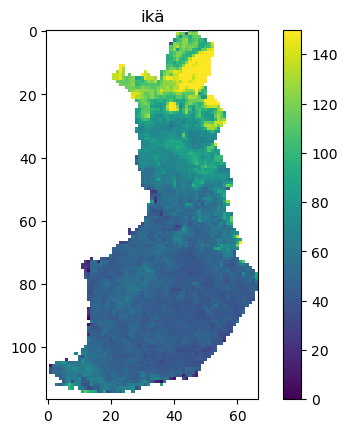

In [36]:
import matplotlib.pyplot as plt

file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10_reproj/reprojected_ika_1_1_1.tif'
with rasterio.open(file) as src:
    data = src.read(1)
    meta = src.meta
    #show(src)
    print(meta)
plt.imshow(data, vmin=0, vmax=150, cmap='viridis')  # replace show(src)
plt.title('ikä')
plt.colorbar()

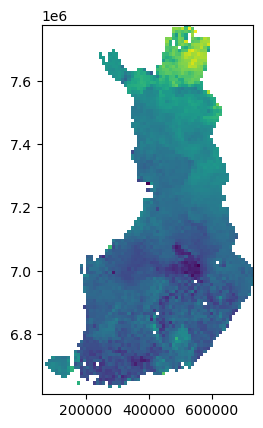

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 67, 'height': 117, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(10000.0, 0.0, 61592.0,
       0.0, -10000.0, 7778312.0)}


In [4]:
file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/classified_mnfi_10x10/resampled_ika_2_2_2.tif'
with rasterio.open(file) as src:
    data = src.read(1)
    meta = src.meta
    show(src)
    print(meta)